<a href="https://colab.research.google.com/github/JanNogga/Vision_Systems_Lab/blob/main/Assignment_3/Assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.optim.lr_scheduler import ReduceLROnPlateau
import random as rand
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
import numpy as np
import joblib
import optuna
from optuna.trial import TrialState
import time

In [2]:
# reject randomness (as much as possible)
manualSeed = 2021

np.random.seed(manualSeed)
rand.seed(manualSeed)
torch.manual_seed(manualSeed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(manualSeed)
    torch.cuda.manual_seed_all(manualSeed)

torch.backends.cudnn.enabled = False 
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

def _init_fn():
    np.random.seed(manualSeed)

In [3]:
### it should be beneficial to use some data augmentation here
transform_train = transforms.Compose(
    [#transforms.RandomCrop(32, padding=4),
     #transforms.RandomHorizontalFlip(),
     #transforms.ColorJitter(brightness=63.0 / 255.0, saturation=[0.5, 1.5], contrast=[0.2, 1.8]),
     transforms.ToTensor(),
     # legends say that these are the true values for SVHN
     transforms.Normalize((0.4376821, 0.4437697, 0.47280442), (0.19803012, 0.20101562, 0.19703614))])
transform_valid = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4376821, 0.4437697, 0.47280442), (0.19803012, 0.20101562, 0.19703614))])

# use this function when we want to plot the images
inv_normalize = transforms.Normalize(
    mean=[-0.4376821/0.19803012, -0.4437697/0.20101562, -0.47280442/0.19703614],
    std=[1/0.19803012, 1/0.20101562, 1/0.19703614]
)



trainset = dsets.SVHN('data', split='train', download=True, transform=transform_train)
testset = dsets.SVHN('data', split='test', download=True, transform=transform_valid)

Using downloaded and verified file: data/train_32x32.mat
Using downloaded and verified file: data/test_32x32.mat


In [4]:
BATCH_SIZE = 1024
train_loader = torch.utils.data.DataLoader(dataset=trainset, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True,
                                           worker_init_fn=_init_fn)
 
valid_loader = torch.utils.data.DataLoader(dataset=testset, 
                                          batch_size=BATCH_SIZE, 
                                          shuffle=False,
                                          worker_init_fn=_init_fn)

In [5]:
# load first study an summarize result
study = joblib.load("SVHN_FC.pkl")
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial_fc = study.best_trial

print("  Value: ", trial_fc.value)

print("  Params: ")
for key, value in trial_fc.params.items():
    print("    {}: {}".format(key, value))

Study statistics: 
  Number of finished trials:  109
  Number of pruned trials:  0
  Number of complete trials:  108
Best trial:
  Value:  87.34250179447861
  Params: 
    z_wide_dim: 2000
    z_narrow_dim: 1000
    p_drop_in: 0.0
    p_drop_hidden: 0.0
    sigma_in: 0.5
    sigma_hidden: 0.0
    num_z_layers: 1
    learning_rate: 0.0002710952848957833


In [6]:
# load the values as found by the study and retrain the network
INPUT_DIM = 3072 # Immutable
Z_WIDE_DIM = trial_fc.params['z_wide_dim'] 
Z_NARROW_DIM = trial_fc.params['z_narrow_dim']
OUTPUT_DIM = 10 # Immutable
LEARNING_RATE = trial_fc.params['learning_rate']
P_DROP_IN = trial_fc.params['p_drop_in']
P_DROP_HIDDEN = trial_fc.params['p_drop_hidden']
SIGMA_IN = trial_fc.params['sigma_in']
SIGMA_HIDDEN = trial_fc.params['sigma_hidden']
NUM_Z_LAYERS = trial_fc.params['num_z_layers']

# network architecture stolen from: https://openreview.net/pdf/1WvovwjA7UMnPB1oinBL.pdf

class GaussianNoise(nn.Module):
    def __init__(self, sigma=0.1, is_relative_detach=True):
        super().__init__()
        self.sigma = sigma
        self.is_relative_detach = is_relative_detach
        self.register_buffer('noise', torch.tensor(0))

    def forward(self, x):
        if self.training and self.sigma != 0:
            scale = self.sigma * x.detach() if self.is_relative_detach else self.sigma * x
            sampled_noise = self.noise.expand(*x.size()).float().normal_() * scale
            x = x + sampled_noise
        return x 

class FC_Model(nn.Module):
    def __init__(self, input_dim=INPUT_DIM, z_wide_dim=Z_WIDE_DIM, z_narrow_dim=Z_NARROW_DIM, output_dim=OUTPUT_DIM, p_drop_in=P_DROP_IN, p_drop_hidden=P_DROP_HIDDEN, sigma_in=SIGMA_IN, sigma_hidden=SIGMA_HIDDEN, num_z_layers=NUM_Z_LAYERS):
        super().__init__()
        self.input_dim = input_dim
        layers = [GaussianNoise(sigma=sigma_in),
                  nn.Dropout(p=p_drop_in),
                  nn.Linear(input_dim, z_wide_dim),
                  GaussianNoise(sigma=sigma_hidden),
                  nn.Dropout(p=p_drop_hidden)]
        for i in range(num_z_layers):
            layers += [nn.Linear(z_wide_dim, z_narrow_dim, bias=False),
                       nn.ReLU(),
                       GaussianNoise(sigma=sigma_hidden),
                       nn.Dropout(p=p_drop_hidden),
                       nn.Linear(z_narrow_dim, z_wide_dim),
                       GaussianNoise(sigma=sigma_hidden),
                       nn.Dropout(p=p_drop_hidden)]
        layers += [nn.Linear(z_wide_dim, output_dim)]
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        x_flat = x.view(-1, self.input_dim)
        out = self.model(x_flat)
        return out

In [7]:
class EarlyStopping(object):
    def __init__(self, mode='min', min_delta=0, patience=7):
        self.mode = mode
        self.min_delta = min_delta
        self.patience = patience
        self.best = None
        self.num_bad_epochs = 0
        self.is_better = None
        
        if mode == 'min':
            self.is_better = lambda a, best: a < best - min_delta
        if mode == 'max':
            self.is_better = lambda a, best: a > best + min_delta

        if patience == 0:
            self.is_better = lambda a, b: True
            self.step = lambda a: False

    def step(self, metrics):
        if self.best is None:
            self.best = metrics
            return False

        if self.is_better(metrics, self.best):
            self.num_bad_epochs = 0
            self.best = metrics
        else:
            self.num_bad_epochs += 1

        if self.num_bad_epochs >= self.patience:
            return True
        return False

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device is : {device}")

Device is : cuda


In [9]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

model = FC_Model()
model = model.to(device)

# Actually enforce 0 mean weights init, this is often quite far off.
with torch.no_grad():
    for param in model.parameters():
        param.data = param.data - param.data.mean()

criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5)

print('Number of trainable parameters:', count_parameters(model))

Number of trainable parameters: 10168010


In [10]:
def epoch_average(losses, counts):
    losses_np = np.array(losses)
    counts_np = np.array(counts)
    weighted_losses = losses_np * counts_np
    return weighted_losses.sum()/counts_np.sum()

In [11]:
start = time.time()
es = EarlyStopping(mode='max', patience=10)

N_EPOCHS = 250
UPDATE_EVERY = 1
train_loss_hist, train_acc_hist, valid_loss_hist, valid_acc_hist  = [], [], [], []
progress_bar = tqdm(range(N_EPOCHS), total=N_EPOCHS, position=0, leave=True)
for epoch in progress_bar:
    train_loss_list, train_acc_list, batch_sizes_train = [], [], []
    valid_loss_list, valid_acc_list, batch_sizes_valid = [], [], []

    model.train()
    for imgs, labels in train_loader:
        optimizer.zero_grad()
        labels = labels.to(device)
        pred_labels = model(imgs.to(device))
        loss = criterion(pred_labels, labels)
    
        loss.backward()
        optimizer.step()

        train_loss_list.append(loss.item())
        batch_sizes_train.append(labels.shape[0])
        pred_label_inds = pred_labels.argmax(dim=-1)
        acc = (pred_label_inds == labels).float().mean() * 100
        train_acc_list.append(acc.item())

    avg_train_loss = epoch_average(train_loss_list, batch_sizes_train)
    avg_train_acc = epoch_average(train_acc_list, batch_sizes_train)
    train_loss_hist.append(avg_train_loss)
    train_acc_hist.append(avg_train_acc)

    model.eval()
    for imgs, labels in valid_loader:
        with torch.no_grad():
            labels = labels.to(device)
            pred_labels = model(imgs.to(device))
            loss = criterion(pred_labels, labels)
            
            valid_loss_list.append(loss.item())
            batch_sizes_valid.append(imgs.shape[0])
            pred_label_inds = pred_labels.argmax(dim=-1)
            acc = (pred_label_inds == labels).float().mean() * 100
            valid_acc_list.append(acc.item())

    avg_valid_loss = epoch_average(valid_loss_list, batch_sizes_valid)
    avg_valid_acc = epoch_average(valid_acc_list, batch_sizes_valid)
    valid_loss_hist.append(avg_valid_loss)
    valid_acc_hist.append(avg_valid_acc)

    if(epoch % UPDATE_EVERY == 0 or epoch == N_EPOCHS-1):
        progress_bar.set_description(f"Epoch {epoch+1} - Train: loss {train_loss_hist[-1]:.4f} | acc {train_acc_hist[-1]:.2f} - Valid: loss {valid_loss_hist[-1]:.4f} | acc {valid_acc_hist[-1]:.2f}. ")

    scheduler.step(avg_valid_loss)
    if(es.step(avg_valid_acc)):
        print('Early stopping triggered!')
        break
print('Training FC took', time.time()-start, 'seconds!')

Epoch 39 - Train: loss 0.2820 | acc 91.93 - Valid: loss 0.5416 | acc 86.94. :  15%|█▌        | 38/250 [07:11<40:09, 11.37s/it]

Early stopping triggered!
Training FC took 431.978483915329 seconds!


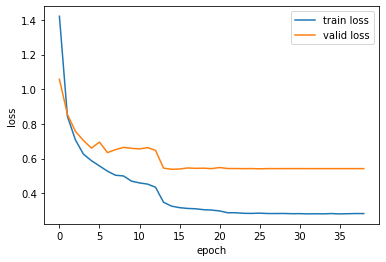

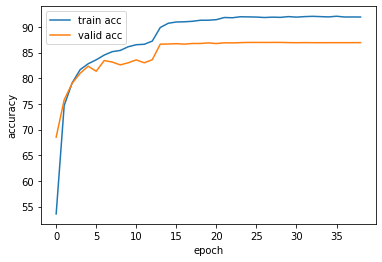

In [12]:
plt.plot(train_loss_hist, label='train loss')
plt.plot(valid_loss_hist, label='valid loss')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.savefig("saved_models/fc_loss.png", dpi=360)
plt.show()


plt.plot(train_acc_hist, label='train acc')
plt.plot(valid_acc_hist, label='valid acc')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.savefig("saved_models/fc_acc.png", dpi=360)
plt.show()

In [13]:
torch.save(model.state_dict(), "saved_models/fc_trained.pt")

In [14]:
# load first study an summarize result
study = joblib.load("SVHN_CONV.pkl")
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial_conv = study.best_trial

print("  Value: ", trial_conv.value)

print("  Params: ")
for key, value in trial_conv.params.items():
    print("    {}: {}".format(key, value))

Study statistics: 
  Number of finished trials:  30
  Number of pruned trials:  0
  Number of complete trials:  29
Best trial:
  Value:  89.37461605904362
  Params: 
    channels_1: 8
    kernel_1: 11
    channels_2: 20
    kernel_2: 5
    fc_1_neurons: 96
    fc_2_neurons: 44
    pool_mode: avg
    p_drop_in: 0.6
    p_drop_conv: 0.0
    p_drop_fc: 0.0
    learning_rate: 0.0010327240125788814


In [15]:
INPUT_CHANNELS = 3 # Immutable
CHANNELS_1 = trial_conv.params['channels_1'] 
KERNEL_1 = trial_conv.params['kernel_1'] 
CHANNELS_2 = trial_conv.params['channels_2'] 
KERNEL_2 = trial_conv.params['kernel_2'] 
FC_1_NEURONS = trial_conv.params['fc_1_neurons'] 
FC_2_NEURONS = trial_conv.params['fc_2_neurons'] 
POOL_MODE = trial_conv.params['pool_mode'] 
P_DROP_FC = trial_conv.params['p_drop_fc'] 
P_DROP_CONV = trial_conv.params['p_drop_conv'] 
P_DROP_IN = trial_conv.params['p_drop_in']
LEARNING_RATE = trial_conv.params['learning_rate']

class Conv_Model(nn.Module):
    def __init__(self, input_channels=INPUT_CHANNELS, channels_1=CHANNELS_1, kernel_1=KERNEL_1, channels_2=CHANNELS_2, kernel_2=KERNEL_2, fc_1_neurons=FC_1_NEURONS, fc_2_neurons=FC_2_NEURONS,pool_mode=POOL_MODE, output_dim=OUTPUT_DIM, p_drop_in=P_DROP_IN, p_drop_conv=P_DROP_CONV, p_drop_fc=P_DROP_FC):
        super().__init__()
        self.drop_in = nn.Dropout2d(p=p_drop_in)
        self.conv1 = nn.Conv2d(input_channels, channels_1, kernel_1, padding=kernel_1//2)
        self.drop_conv = nn.Dropout2d(p=p_drop_conv)
        if pool_mode == 'max':
            self.pool = nn.MaxPool2d(2, 2)
            self.out_size = 8
        elif pool_mode == 'avg':
            self.pool = nn.AvgPool2d(2,2)
            self.out_size = 8
        else:
            self.pool = lambda x: x
            self.out_size = 32
        self.conv2 = nn.Conv2d(channels_1, channels_2, kernel_2, padding=kernel_2//2)
        self.fc1 = nn.Linear(channels_2 * self.out_size * self.out_size, fc_1_neurons)
        self.drop_fc = nn.Dropout(p=p_drop_fc)
        self.fc2 = nn.Linear(fc_1_neurons, fc_2_neurons)
        self.fc3 = nn.Linear(fc_2_neurons, output_dim)

    def forward(self, x):
        x = self.drop_in(x)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.drop_conv(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.drop_conv(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.drop_fc(x)
        x = F.relu(self.fc2(x))
        x = self.drop_fc(x)
        x = self.fc3(x)
        return x

In [16]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

model = Conv_Model()
model = model.to(device)

# Actually enforce 0 mean weights init, this is often quite far off.
with torch.no_grad():
    for param in model.parameters():
        param.data = param.data - param.data.mean()

criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5)

print('Number of trainable parameters:', count_parameters(model))

Number of trainable parameters: 134626


In [17]:
start = time.time()
es = EarlyStopping(mode='max', patience=10)

UPDATE_EVERY = 1
train_loss_hist, train_acc_hist, valid_loss_hist, valid_acc_hist  = [], [], [], []
progress_bar = tqdm(range(N_EPOCHS), total=N_EPOCHS, position=0, leave=True)
for epoch in progress_bar:
    train_loss_list, train_acc_list, batch_sizes_train = [], [], []
    valid_loss_list, valid_acc_list, batch_sizes_valid = [], [], []

    model.train()
    for imgs, labels in train_loader:
        optimizer.zero_grad()
        labels = labels.to(device)
        pred_labels = model(imgs.to(device))
        loss = criterion(pred_labels, labels)
    
        loss.backward()
        optimizer.step()

        train_loss_list.append(loss.item())
        batch_sizes_train.append(labels.shape[0])
        pred_label_inds = pred_labels.argmax(dim=-1)
        acc = (pred_label_inds == labels).float().mean() * 100
        train_acc_list.append(acc.item())

    avg_train_loss = epoch_average(train_loss_list, batch_sizes_train)
    avg_train_acc = epoch_average(train_acc_list, batch_sizes_train)
    train_loss_hist.append(avg_train_loss)
    train_acc_hist.append(avg_train_acc)

    model.eval()
    for imgs, labels in valid_loader:
        with torch.no_grad():
            labels = labels.to(device)
            pred_labels = model(imgs.to(device))
            loss = criterion(pred_labels, labels)
            
            valid_loss_list.append(loss.item())
            batch_sizes_valid.append(imgs.shape[0])
            pred_label_inds = pred_labels.argmax(dim=-1)
            acc = (pred_label_inds == labels).float().mean() * 100
            valid_acc_list.append(acc.item())

    avg_valid_loss = epoch_average(valid_loss_list, batch_sizes_valid)
    avg_valid_acc = epoch_average(valid_acc_list, batch_sizes_valid)
    valid_loss_hist.append(avg_valid_loss)
    valid_acc_hist.append(avg_valid_acc)

    if(epoch % UPDATE_EVERY == 0 or epoch == N_EPOCHS-1):
        progress_bar.set_description(f"Epoch {epoch+1} - Train: loss {train_loss_hist[-1]:.4f} | acc {train_acc_hist[-1]:.2f} - Valid: loss {valid_loss_hist[-1]:.4f} | acc {valid_acc_hist[-1]:.2f}. ")

    scheduler.step(avg_valid_loss)
    if(es.step(avg_valid_acc)):
        print('Early stopping triggered!')
        break
print('Training Conv took', time.time()-start, 'seconds!')

Epoch 69 - Train: loss 0.6055 | acc 79.27 - Valid: loss 0.3931 | acc 89.65. :  27%|██▋       | 68/250 [29:07<1:17:56, 25.69s/it]

Early stopping triggered!
Training Conv took 1747.2185311317444 seconds!


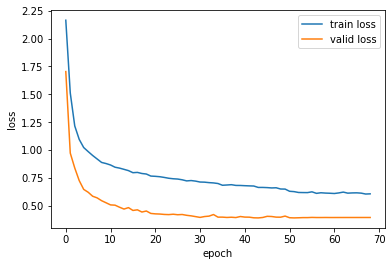

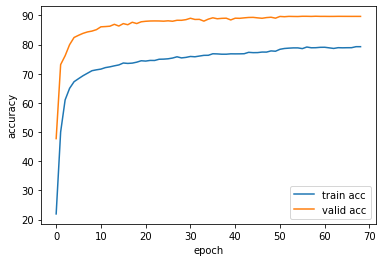

In [18]:
plt.plot(train_loss_hist, label='train loss')
plt.plot(valid_loss_hist, label='valid loss')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.savefig("saved_models/conv_loss.png", dpi=360)
plt.show()


plt.plot(train_acc_hist, label='train acc')
plt.plot(valid_acc_hist, label='valid acc')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.savefig("saved_models/conv_acc.png", dpi=360)
plt.show()

In [19]:
torch.save(model.state_dict(), "saved_models/conv_trained.pt")